## Exploratory Analysis of Vancouver Crime Data:

### I will explore the Vancouver crime records from 2003 to 2019.
### The dataset is collected from the City of Vancouver's [Open Data Catalogue](https://data.vancouver.ca/datacatalogue/crime-data.htm)
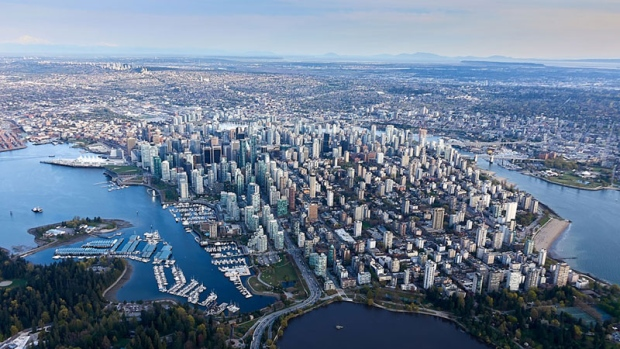

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

## 1. Input Dataset First

In [ ]:
crime_records = pd.read_csv("../input/crime_records.csv")
crime_records.head()

## 2. Quick dataset summary

### 2.0 Do we have missing data?

In [ ]:
# my personal reusable function for detecting missing data
def missing_value_describe(data):
    # check missing values in training data
    missing_value_stats = (data.isnull().sum() / len(data)*100)
    missing_value_col_count = sum(missing_value_stats > 0)
    missing_value_stats = missing_value_stats.sort_values(ascending=False)[:missing_value_col_count]
    print("Number of columns with missing values:", missing_value_col_count)
    if missing_value_col_count != 0:
        # print out column names with missing value percentage
        print("\nMissing percentage (desceding):")
        print(missing_value_stats)
    else:
        print("No missing data!!!")
missing_value_describe(crime_records)

### From the above missing data examination, we can we have 4 columns with missing data: they are NEIGHHOURHOOD (10.42% missing), MINUTE(10.02% missing), HOUR(10.02% missing), and HUNDRED_BLOCK(0.002% missing).

### The missing percentage of MINUTE and HOUR columns are the same. That makes sense because they are recorded together. However, the HUNDRED_BLOCk, which is the physical address, has ~10% lower missing value than the NEIGHBOURHOOD column. What can be the cause? It turnes out they "uses the Statistics Canada definition of neighbourhoods within municipalities. Neighbourhoods within the City of Vancouver are based on the census tract (CT) concept within census metropolitan area (CMA)." The missing NEIGHBOURHOOD columns might be caused by unlabeled neighbourhoods in the Statistics Canada dataset or they just aren't labeled.

### I am thinking about create a dictionary for each street-neighbourhood pair to predict the missing neighbourhood. I will do it later.

## 2.1 Dimension of dataset

In [ ]:
print("the dimension:", crime_records.shape)

### We have over 600K rows and 10 columns in our dataset.

## 3. Distribution of each type of crime:

In [ ]:
crime_records['TYPE'].value_counts()

In [ ]:
# crime type distribution
nameplot = crime_records['TYPE'].value_counts().plot.bar(title='Count of each type of crime happened in Vancouver', figsize=(8,6))
nameplot.set_xlabel('category',size=20)
nameplot.set_ylabel('crime count',size=20)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatterpolar(
  r=crime_records['TYPE'].value_counts(),
  theta=crime_records['TYPE'].value_counts().index,
  fill='toself'
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
        visible=True
     ),
    ),
    showlegend=False,
    title_text="Vancouver Crime Record Radar Chart by Crime Type",
    autosize=True
)

fig.show()

### It appears that the most common type of is associated with vehicle in Vancouver: Theft from Vehicle, Theft of Vehicle, Theft of Bicycle and Vehicle Collision. Since 2003, there are 209609 crime categorized as "Theft from Vehicle".

## 3.1 Has the crime decreased over the years in Vancouver?

In [ ]:
"""
Create empty dataframe to store the crime count over the years in Vancouver
"""
# year values
year_labels = sorted(crime_records["YEAR"].unique())

# crime types
crime_types = sorted(crime_records["TYPE"].unique().tolist())

# Create the pandas DataFrame 
crime_count_by_year = pd.DataFrame(columns =["year"]) 
crime_count_by_year["year"] = year_labels
crime_count_by_year

In [ ]:
# gather yearly count of crime in Vancouver
for current_type in crime_types:
    current_crime = crime_records[crime_records["TYPE"]==current_type]
    current_crime_counts = current_crime["YEAR"].value_counts(sort=False)
    current_crime_index = current_crime_counts.index.tolist()
    current_crime_index, current_crime_counts = zip(*sorted(zip(current_crime_index, current_crime_counts)))
    crime_count_by_year[current_type] = current_crime_counts
crime_count_by_year

### Let's visualize the change of crime over the years across all the types of crime:

In [ ]:
# Create traces
fig = go.Figure()
for current_crime in crime_types:
    current_type_count = crime_count_by_year[current_crime]
    fig.add_trace(
        go.Scatter(
            x=year_labels, 
            y=current_type_count,
            mode='lines+markers',
            name=current_crime
        )
    )
# Edit the layout
fig.update_layout(title='Crimes Over the Years in Vancouver by Type',
                    xaxis_title='Year',
                    yaxis_title='Absolute Change',
                    autosize=True,
                    height=570
                 )

fig.update_layout(legend_orientation="h")

fig.show()

### Percent change of crime count over the years using 2003 as the baseline:

In [ ]:
baseline_year = crime_count_by_year.iloc[0,1:]
crime_count_by_year_percent_change = 100 * round((crime_count_by_year.iloc[:,1:] - baseline_year) / baseline_year, 2)
crime_count_by_year_percent_change["year"] = year_labels
crime_count_by_year_percent_change

In [ ]:
# Create traces
fig = go.Figure()
for current_crime in crime_types:
    current_type_count = crime_count_by_year_percent_change[current_crime]
    fig.add_trace(
        go.Scatter(
            x=year_labels, 
            y=current_type_count,
            mode='lines+markers',
            name=current_crime
        )
    )
# Edit the layout
fig.update_layout(title='Percent Change of Crimes Over the Years in Vancouver by Type',
                    xaxis_title='Year',
                    yaxis_title='Percent Change (%)',
                    autosize=True,
                    height=570
                 )
fig.update_layout(legend_orientation="h")
fig.show()

### Using the crime count of 2003 for each category as the baseline, you can observe that the crimes of "Theft of Bicycle" and "Other Theft" have increased over the years relative speaking. "Offence Against a Person" crimes has increased continuously from 2004 to 2013 and then decreased compared to 2003. Overally, there are less crimes in the remaining categories comparing to 2003.

### Below are the absolute crime count over the years from 2003 to 2019.

In [ ]:
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=6, cols=2,
    subplot_titles=[str(i+1) + ". " + crime_types[i] for i in range(len(crime_types))]
)

# function to update row and col for adding subplots
current_row = 1
current_col = 1
def update_row_col(current_row, current_col):
    if current_col < 2:
        current_col += 1
    else:
        current_col = 1
        current_row += 1
    return current_row, current_col

# add trace to the subplot
current_count = 1
for current_crime in crime_types:
    current_type_count = crime_count_by_year[current_crime]
    fig.add_trace(
        go.Scatter(
            x=year_labels, 
            y=current_type_count,
            mode='lines+markers',
            name=current_crime
        ),
        row=current_row, col=current_col
    )
    current_row, current_col = update_row_col(current_row, current_col)

fig.update_layout(
    height=1500, 
    width=900,
    title_text="Crimes in Vancouver Over the Years"
)

fig.update_layout(legend_orientation="h")
fig.show()

## 4. Crime records by month:

### 4.1 What months have the most of the crimes recorded?

In [ ]:
average_crime_count_by_month = crime_records.groupby(["YEAR", "MONTH"]).size().reset_index(name='counts').groupby("MONTH").mean().round()
average_crime_count_by_month.reset_index().plot.bar(title='Average count of crime happened in each month from 2003 to 2019', 
                                                    x = "MONTH", y = "counts",
                                                    figsize=(8,6))
nameplot.set_xlabel('month',size=20)
nameplot.set_ylabel('crime count',size=20)

### It appears that the months of summer time has more crime recorded than other months.

## 5. Crime investigation based on location data

### We have 4 columns describe the locations of the given crime records. They are: HUNDRED_BLOCK, NEIGHBOURHOOD, X, and Y. Let's explore these columns now. 

### 5.1 How many unique blocks do we have?

In [ ]:
len(crime_records["HUNDRED_BLOCK"].unique())

### That's a lot of blocks! Let's find out:
### 5.2 What are the top 10 crime populated block based on crime data?

In [ ]:
crime_records["HUNDRED_BLOCK"].value_counts()[:10].plot.bar(
    title='Top 10 Dangerous Blocks in Vancouver')
nameplot.set_xlabel('block name',size=20)
nameplot.set_ylabel('count',size=20)

### To protect privacy, police labeled about 10% of the data to be "OFFSET TO PROTECT PRIVACY". Let's graph the top 10 crime-populated block without the "OFFSET TO PROTECT PRIVACY" rows. 

In [ ]:
crime_records["HUNDRED_BLOCK"].value_counts()[1:11].plot.bar(
    title='Top 10 Dangerous Blocks in Vancouver')
nameplot.set_xlabel('block name',size=20)
nameplot.set_ylabel('count',size=20)

### Granville street seems to be very dangerous from the above visualization.

### Well, 60K of 609K rows of data are offsetted to protect privacy. We won't be able to use those data because the HUNDRED_BLOCK, NEIGHBOURHOOD data, X, and Y data will be inaccurate to describe the crime happened in Vancouver from 2003 to 2019. Let's create a new dataframe with usable data that's not labeled as "OFFSET TO PROTECT PRIVACY".

In [ ]:
crime_records_without_offset = crime_records[crime_records["HUNDRED_BLOCK"] != "OFFSET TO PROTECT PRIVACY"]
crime_records_without_offset.shape

### 5.3 Let's build a simple dictionary to match the missing NEIGHBOURHOOD column's data to see if it's viable or not in order to reduce the number of missing data.

### We are not interested in block number anymore. Let's remove the number by stripping the first block before the first white space in the HUNDRED_BLOCK data.

In [ ]:
# drop missing row in crime record where only 0.002% of HUNDRED_BLOCK row are missing
crime_records_without_offset = crime_records_without_offset[pd.notnull(crime_records_without_offset["HUNDRED_BLOCK"])]

In [ ]:
block_names = crime_records_without_offset["HUNDRED_BLOCK"]
block_names.isnull().sum() # make sure we don't have missing row for HUNDRED_BLOCK now

### If the street number's first character is a number and the street's name has more than 2 word, I remove the street number from it.
### Reason:
#### 1. The street name's beginning can a letter which is not a street number. I don't want the location information lost through this preprocessing process.
#### 2. The street name can be 2 words only such as Hasting Street. I don't want the first word to be lost and let the dataset only contains the "street" part.

In [ ]:
def remove_street_number(street_name):
    # if the beginning is a digit and the street name contains more than 2 words
    if street_name[0].isdigit() and len(street_name.split(" ")) > 2:
        _, _, tail = street_name.partition(" ")
        return tail
    return street_name

# apply the above function to remove the street number in each row
crime_records_without_offset["HUNDRED_BLOCK"] = block_names.apply(remove_street_number)

In [ ]:
crime_records_without_offset["HUNDRED_BLOCK"].head()

### We have successfully removed the block number. Now, let's associate the block name to the neighbourhood data to create a dictionary to check whether the missing neighbourhood data's street has association with existing block already.

In [ ]:
street_with_missing_neighbourhood = crime_records_without_offset[crime_records_without_offset["NEIGHBOURHOOD"].isnull()]["HUNDRED_BLOCK"].value_counts()
street_with_missing_neighbourhood

### What is "NK_LOC ST"?
### The Vancouver city website states it is default location value used for incidents with unknown location. Let's drop them for our spatial anaylsis.

In [ ]:
crime_records_without_offset = crime_records_without_offset[crime_records_without_offset["HUNDRED_BLOCK"]!="X NK_LOC ST"]
crime_records_without_offset = crime_records_without_offset[crime_records_without_offset["HUNDRED_BLOCK"]!='X NK_LOC ST "SQUAMISH"']
crime_records_without_offset = crime_records_without_offset[crime_records_without_offset["HUNDRED_BLOCK"]!='X NK_LOC ST "UBC"']

In [ ]:
street_with_missing_neighbourhood = crime_records_without_offset[crime_records_without_offset["NEIGHBOURHOOD"].isnull()]["HUNDRED_BLOCK"].value_counts()
street_with_missing_neighbourhood

### Create a dictionary of block-neighbourhood pair

In [ ]:
street_neighbour_dict = {}

# iterate over rows with iterrows()
for index, row in crime_records_without_offset.iterrows():
    # access data using column names
    if pd.isnull(row["NEIGHBOURHOOD"]) == False:
        street_neighbour_dict[row["HUNDRED_BLOCK"]] = row["NEIGHBOURHOOD"]

In [ ]:
# checking if the missing neighbourhood value for existing street is included
# in the dictionary I created above
existed_street_block_association = []
count = 0
for name in street_with_missing_neighbourhood.index.tolist():
    existed = False
    if name in street_neighbour_dict:
        existed_street_block_association.append(name)
        existed = True
        count += 1
print(count, "names are are existed in the dictionary")

In [ ]:
existed_street_block_association

### Let's assign the street-neighbourhood dictionary values to fill the missing values.

In [ ]:
# fill missing neighbourhood value with dictionary created above
for name in existed_street_block_association:
    crime_records_without_offset.loc[crime_records_without_offset["HUNDRED_BLOCK"] == name, "NEIGHBOURHOOD"] = street_neighbour_dict[name]

In [ ]:
# reusable function to check the missing neighbourhood value
def missing_neighbourhood_val_count():
    return crime_records_without_offset[crime_records_without_offset["NEIGHBOURHOOD"].isnull()]["HUNDRED_BLOCK"].value_counts()
missing_neighbourhood_val_count()

### We have 5 rows left. Let's look at online neighbourhood map and the dataset before I remove the street number to assign NEIGHBOURHOOD column value to them.
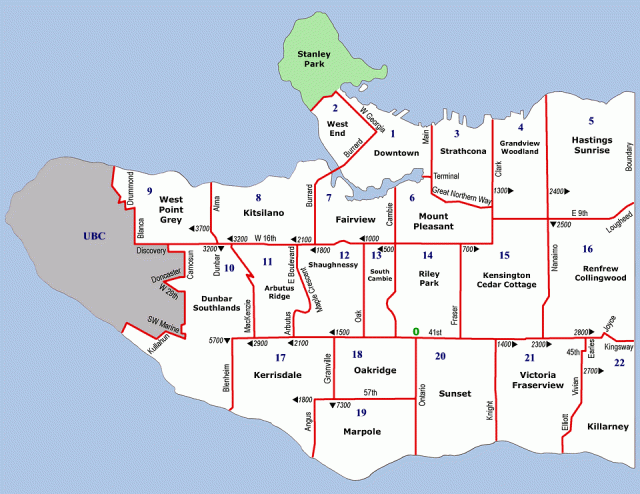

### After reviewing openStreetMap, I found out that:
#### 1. MARINE DR / TAMATH CRES is belong to the Dunbar-southlands neighbourhood, althought it's within the edge of UBC area.

In [ ]:
crime_records_without_offset.loc[crime_records_without_offset["HUNDRED_BLOCK"]=="SW MARINE DR / TAMATH CRES","NEIGHBOURHOOD"] = "Dunbar-Southlands"
missing_neighbourhood_val_count()

#### 2. Victoria Avenue is actually belong to a city called White Rock. From the Vancouver neighbourhood map, it's not included. Let's drop it from the dataset.

In [ ]:
crime_records_without_offset = crime_records_without_offset[crime_records_without_offset["HUNDRED_BLOCK"]!="BLOCK VICTORIA AVE"]
missing_neighbourhood_val_count()

### 3. Granville St / 58th Avenue belongs to the Kerrisdale neighbourhood.

In [ ]:
crime_records_without_offset.loc[crime_records_without_offset["HUNDRED_BLOCK"]=="GRANVILLE ST / 58TH AVE","NEIGHBOURHOOD"] = "Kerrisdale"
missing_neighbourhood_val_count()

### S / L block intersection is actually 30 minutes drive away from Hastings Street. Let's not replace value for now since it's only 1 of 600K data row. I will assign neighbourhood value to it after I examine the longtitude and latitude data later.

In [ ]:
crime_records_without_offset["NEIGHBOURHOOD"].unique()

### 5.4 Top 10 most dangerous neighbourhood in Vancouver

In [ ]:
crime_records["NEIGHBOURHOOD"].value_counts()[1:11].plot.bar(
    title='Top 10 Dangerous Neighbourhood in Vancouver', color="orange")
nameplot.set_xlabel('neighhourhood name',size=20)
nameplot.set_ylabel('count',size=20)

### It turns out the most crime populated neighbourhood is West End.


In [ ]:
# crimes in west end
west_end_crimes = crime_records_without_offset[crime_records_without_offset["NEIGHBOURHOOD"]=="West End"]
values = west_end_crimes["TYPE"].value_counts()
labels = values.index.tolist()
labels

### 8 of 1328 collision resulted fatality. The "or" really makes the data unclear and they didn't state the total death count.

### Let's combine the last two element of the list together and reduce the string length for better visualization.

In [ ]:
labels.pop()
labels[-1] = "Veh. Collis/ Ped Struck"
labels

In [ ]:
values[-2] += values[-1]
values = values[:len(values)-1]
values

In [ ]:
fig = go.Figure(data=[go.Pie(labels=values.index, values=values, hole=.3)])
fig.show()

### Among all the crime records of West End neighbourhood, the majority crime records are from the category of "Theft from Vehicle" with 41.9% of the total record entries.

### Let's take a look the x and y values of the crime happened in West End neighbourhood.

In [ ]:
import squarify
import matplotlib.colors
import matplotlib.cm
import matplotlib.pyplot as plt

In [ ]:
west_end_X = crime_records_without_offset[crime_records_without_offset["NEIGHBOURHOOD"]=="West End"]["X"]
west_end_Y = crime_records_without_offset[crime_records_without_offset["NEIGHBOURHOOD"]=="West End"]["Y"]
plt.scatter(west_end_X,west_end_Y, color="red", marker=".")
plt.xlabel("X")
plt.ylabel("Y")
plt.title('Crimes Happened in West End from 2003 to 2019') 
plt.show()

### The scatter plot is actually the shape of the West End neighbourhood.

### Crimes happened on almost every street of West End from 2003 to 2019.

In [ ]:
cimes_2003 = crime_records_without_offset[crime_records_without_offset["YEAR"]==2003]
west_end_X_2003 = cimes_2003[cimes_2003["NEIGHBOURHOOD"]=="West End"]["X"]
west_end_Y_2003 = cimes_2003[cimes_2003["NEIGHBOURHOOD"]=="West End"]["Y"]
plt.scatter(west_end_X_2003,west_end_Y_2003, color="brown", marker=".")
plt.xlabel("X")
plt.ylabel("Y")
plt.title('Crimes Happened in West End in 2003') 
plt.show()

In [ ]:
cimes_2019 = crime_records_without_offset[crime_records_without_offset["YEAR"]==2019]
west_end_X_2019 = cimes_2019[cimes_2019["NEIGHBOURHOOD"]=="West End"]["X"]
west_end_Y_2019 = cimes_2019[cimes_2019["NEIGHBOURHOOD"]=="West End"]["Y"]
plt.scatter(west_end_X_2019,west_end_Y_2019, color="orange", marker=".")
plt.xlabel("X")
plt.ylabel("Y")
plt.title('Crimes Happened in West End in 2019') 
plt.show()

### Comparing the X, and Y of records from West End, the above plots show the crimes scattered through the neighbourhood and depicted almost the full street map of the West End neighbourhood.

## 6. Vancouver Crimes Heatmap with Folium 
### Convert UTM to Longtitude and Latitude system.
### See my Github repository with modified code: https://github.com/KangboLu/UTM-to-Longtitude-Latitude-System

In [ ]:
import math

def utmToLatLong(utmEasting, utmNorthing, utmZone):
    eastingOffset = 500000.0
    northingOffset = 10000000.0
    k0 = 0.9996
    equatorialRadius = 6378137.0
    eccSquared = 0.006694380023
    eccPrimeSquared = eccSquared / (1 - eccSquared)
    e1 = (1 - math.sqrt(1 - eccSquared)) / (1 + math.sqrt(1 - eccSquared));
    rad2deg = 180.0/math.pi

    # Casts input from string to floats or ints
    # Removes 500,000 metre offset for longitude
    xUTM = float(utmEasting) - eastingOffset
    yUTM = float(utmNorthing)
    zoneNumber = int(utmZone)

    # Finds the origin longitude for the zone
    lonOrigin = (zoneNumber - 1) * 6 - 180 + 3 # +3 puts in zone centre

    M = yUTM / k0 #This finds the meridional arc
    mu = M / (equatorialRadius * (1- eccSquared / 4 - 3 * eccSquared * eccSquared / 64 -5 * eccSquared * eccSquared * eccSquared /256))

    # Calculates the footprint latitude
    phi1Rad = mu + (3 * e1 / 2 - 27 * e1 * e1 * e1 /32) * math.sin(2*mu) + ( 21 * e1 * e1 / 16 - 55 * e1 * e1 * e1 * e1 / 32) * math.sin( 4 * mu) + (151 * e1 * e1 * e1 / 96) * math.sin(6 * mu)
    phi1 = phi1Rad * rad2deg

    # Variables for conversion equations
    N1 = equatorialRadius / math.sqrt( 1 - eccSquared * math.sin(phi1Rad) *  math.sin(phi1Rad))
    T1 = math.tan(phi1Rad) * math.tan(phi1Rad)
    C1 = eccPrimeSquared * math.cos(phi1Rad) * math.cos(phi1Rad)
    R1 = equatorialRadius * (1 - eccSquared) / math.pow(1 - eccSquared * math.sin(phi1Rad) * math.sin(phi1Rad), 1.5)
    D = xUTM / (N1 * k0)

    # Calculate latitude, in decimal degrees
    lat = phi1Rad - ( N1 * math.tan(phi1Rad) / R1) * (D * D / 2 - (5 + 3 * T1 + 10 * C1 - 4 * C1 * C1 - 9 * eccPrimeSquared) * D * D * D * D / 24 + (61 + 90 * T1 + 298 * C1 + 45 * T1 * T1 - 252 * eccPrimeSquared - 3 * C1 * C1) * D * D * D * D * D * D / 720)
    lat = lat * rad2deg
    
    # Calculate longitude, in decimal degrees
    lon = (D - (1 + 2 * T1 + C1) * D * D * D / 6 + (5 - 2 * C1 + 28 * T1 - 3 * C1 * C1 + 8 * eccPrimeSquared + 24 * T1 * T1) * D * D * D * D * D / 120) / math.cos(phi1Rad)
    lon = lonOrigin + lon * rad2deg
    
    return lon, lat

In [ ]:
crime_records_without_offset = crime_records_without_offset.reset_index(drop=True)

In [ ]:
crimes_vancouver_X = crime_records_without_offset["X"]
crimes_vancouver_Y = crime_records_without_offset["Y"]
longtitude = []
latitude = []
for i in range(len(crimes_vancouver_X)):
    lon, lat = utmToLatLong(crimes_vancouver_X[i], crimes_vancouver_Y[i], 10)
    longtitude.append(lon)
    latitude.append(lat)

In [ ]:
crime_records_without_offset["LONGTITUDE"] = longtitude
crime_records_without_offset["LATITUDE"] = latitude
crime_records_without_offset.head()

### We have the latitude and longtitude value now! let's find out where should the neighbourhood be for the record with "S / L 300 BLK E HASTINGS ST" HUNDRED_BLOCK value.

In [ ]:
missing_neighbourhood = crime_records_without_offset[crime_records_without_offset["HUNDRED_BLOCK"]=="S / L 300 BLK E HASTINGS ST"]
missing_neighbourhood_Lon = missing_neighbourhood["LONGTITUDE"]
missing_neighbourhood_Lat = missing_neighbourhood["LATITUDE"]
lat_lon_pair = list(zip(missing_neighbourhood_Lat, missing_neighbourhood_Lon))
print("Latitude and Longtitude of the missing neighbourhood row")
lat_lon_pair

### I will use folium for heatmap and clusterMarker data visualization

In [ ]:
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster

In [ ]:
print("Where is the missing neighbourhood row located?")
missing_neighbourhood_vis = folium.Map(location= [49.4985,-123.8159], 
                           tiles = "Stamen Terrain",
                           zoom_start = 9)
popups = ["Missing Neighbourhood Record"]
MarkerCluster(lat_lon_pair, popups=popups).add_to(missing_neighbourhood_vis)
missing_neighbourhood_vis

### It turns out that's far away from the city of Vancouver. Let's consider it as an outlier and remove it from the dataset. 

In [ ]:
# not include the row in our analysis
crime_records_without_offset = crime_records_without_offset[crime_records_without_offset["HUNDRED_BLOCK"]!="S / L 300 BLK E HASTINGS ST"]
crime_records_without_offset = crime_records_without_offset.reset_index(drop=True) # reset index
missing_neighbourhood_val_count() # checking missing neighbourhood value

In [ ]:
missing_value_describe(crime_records_without_offset)

### After working hard on associating street to neibouhoood for filling the missing data and manually cleaning the exceptions and outliers. We now reduced the missing percentages from 10% to about 0.02%. I will drop the remaining missing rows.

In [ ]:
crime_records_without_offset = crime_records_without_offset.dropna()

In [ ]:
missing_value_describe(crime_records_without_offset)

In [ ]:
# return a list of latitude and longtitude data based on specified year
def get_record_locations_by_year(year):
    lat = crime_records_without_offset.query("YEAR == @year")["LATITUDE"]
    lon = crime_records_without_offset.query("YEAR == @year")["LONGTITUDE"]
    return list(zip(lat, lon))

### Let's take a look at the crime heatmap of 2019 so far
### Feel free to zoom in and play with it!

In [ ]:
latlon_2019 = get_record_locations_by_year(2019)
crime_heatmap = folium.Map(location= [49.24, -123.11], 
                           tiles = "Stamen Toner",
                           zoom_start = 12)
HeatMap(latlon_2019, min_opacity=0.05).add_to(crime_heatmap)
crime_heatmap

### You can clearly see that the north regions are relative more crime populated. Let's zoom in to see to the crimes in West End (2019).

In [ ]:
# return a list of latitude and longtitude data based on specified year and crime type
def get_record_locations_by_year_and_neighbourhood(year, neighbourhood):
    crimes = crime_records_without_offset[crime_records_without_offset["YEAR"]==year]
    lat = crimes.query("NEIGHBOURHOOD == @neighbourhood")["LATITUDE"]
    lon = crimes.query("NEIGHBOURHOOD == @neighbourhood")["LONGTITUDE"]
    return list(zip(lat, lon))

In [ ]:
latlon_west_end_2019 = get_record_locations_by_year_and_neighbourhood(2019, "West End")
crime_heatmap = folium.Map(location= [49.28416, -123.13150], 
                           tiles = "Stamen Toner",
                           zoom_start = 14.5)
HeatMap(latlon_west_end_2019, min_opacity=0.05).add_to(crime_heatmap)
crime_heatmap

In [ ]:
# return a list of latitude and longtitude data based on specified year and crime type
def get_record_locations_by_year_and_type(year, crime_type):
    crimes = crime_records_without_offset.query("YEAR == @year")
    lat = crimes[crimes["TYPE"]==crime_type]["LATITUDE"]
    lon = crimes[crimes["TYPE"]==crime_type]["LONGTITUDE"]
    return list(zip(lat, lon))

# return a list of latitude and longtitude data based on specified year and crime type
def get_record_locations_by_year_type_neighbourhood(year, crime_type, neighbourhood):
    crimes = crime_records_without_offset.query("YEAR == @year")
    crimes = crimes[crimes["NEIGHBOURHOOD"]==neighbourhood]
    lat = crimes[crimes["TYPE"]==crime_type]["LATITUDE"]
    lon = crimes[crimes["TYPE"]==crime_type]["LONGTITUDE"]
    return list(zip(lat, lon))

### Let's take look at the "Theft from Vehicle" crimes in West End (2019)

In [ ]:
print("West End 'Theft from Vehicle' crime heatmap in 2019")
latlon_west_end_2019 = get_record_locations_by_year_type_neighbourhood(2019, "Theft from Vehicle", "West End")
crime_heatmap = folium.Map(location= [49.28416, -123.13150], 
                           tiles = "Stamen Toner",
                           zoom_start = 14.5)
HeatMap(latlon_west_end_2019, min_opacity=0.05).add_to(crime_heatmap)
crime_heatmap

In [ ]:
print("West End 'Theft from Vehicle' crime markers in 2019")
latlon_west_end_2019 = get_record_locations_by_year_type_neighbourhood(2019, "Theft from Vehicle", "West End")
west_end_TFC = folium.Map(location= [49.28416, -123.13150], 
                           tiles = "Stamen Terrain",
                           zoom_start = 15)
popups = ["Theft from Vehicle" for _ in range(len(latlon_west_end_2019))] # Popups texts are simple numbers.
MarkerCluster(latlon_west_end_2019, popups=popups).add_to(west_end_TFC)
west_end_TFC

### Let's also take look at the "Theft of Bicyle" crimes in West End and in the entire Vancouver neighbourhood in general for 2019.

In [ ]:
print("West End 'Theft of Bicycle' crime heatmap in 2019")
latlon_west_end_2019 = get_record_locations_by_year_type_neighbourhood(2019, "Theft of Bicycle", "West End")
crime_heatmap = folium.Map(location= [49.28416, -123.13150], 
                           tiles = "Stamen Toner",
                           zoom_start = 14.5)
HeatMap(latlon_west_end_2019).add_to(crime_heatmap)
crime_heatmap

In [ ]:
print("West End 'Theft of Bicycle' crimer markers in 2019")
latlon_west_end_2019 = get_record_locations_by_year_type_neighbourhood(2019, "Theft of Bicycle", "West End")
west_end_TFC = folium.Map(location= [49.28416, -123.13150], 
                           tiles = "Stamen Terrain",
                           zoom_start = 15)
popups = ["Theft of Bicycle" for _ in range(len(latlon_west_end_2019))] # Popups texts are simple numbers.
MarkerCluster(latlon_west_end_2019, popups=popups).add_to(west_end_TFC)
west_end_TFC

In [ ]:
print("Vancouver 'Theft of Bicycle' crime heatmap in 2019")
latlon_west_end_2019 = get_record_locations_by_year_and_type(2019, "Theft of Bicycle")
crime_heatmap = folium.Map(location= [49.24, -123.11], 
                           tiles = "Stamen Toner",
                           zoom_start = 12)
HeatMap(latlon_west_end_2019, min_opacity=0.4, radius=15).add_to(crime_heatmap)
crime_heatmap

In [ ]:
print("Vancouver 'Theft of Bicycle' crimer markers in 2019")
west_end_TFC = folium.Map(location= [49.24, -123.11], 
                           tiles = "Stamen Terrain",
                           zoom_start = 12)
popups = ["Theft of Bicycle" for _ in range(len(latlon_west_end_2019))] # Popups texts are simple numbers.
MarkerCluster(latlon_west_end_2019, popups=popups).add_to(west_end_TFC)
west_end_TFC

### The theft of bicycle crimes follow the similar pattern comparing to the overall spatial distribution of the crimes in Vancouver for 2019.

### Let's apply same type of graph to Stanley Park, which is popular sight.
### Feel free to zoom in!

In [ ]:
print("Crimes happened in Stanley Park in 2019 so far")
latlon_stanely_park_2019 = get_record_locations_by_year_and_neighbourhood(2019, "Stanley Park")
crime_heatmap = folium.Map(location= [49.30330, -123.14635], 
                           tiles = "Stamen Toner",
                           zoom_start = 15)
HeatMap(latlon_stanely_park_2019).add_to(crime_heatmap)
crime_heatmap

In [ ]:
def get_crime_types(year, neighbourhood):
    crimes = crime_records_without_offset[crime_records_without_offset["YEAR"]==year]
    crime_types = crimes[crimes["NEIGHBOURHOOD"]==neighbourhood]["TYPE"]
    return crime_types

In [ ]:
print("Crimes happened in Stanley Park in 2019 so far")
latlon_stanely_park_2019 = get_record_locations_by_year_and_neighbourhood(2019, "Stanley Park")
crime_clusterMarkers = folium.Map(location= [49.30330, -123.14635], 
                           tiles = "Stamen Toner",
                           zoom_start = 15)
popups = [i for i in get_crime_types(2019, "Stanley Park")] # Popups texts are simple numbers.
MarkerCluster(latlon_stanely_park_2019, popups=popups).add_to(crime_clusterMarkers)
crime_clusterMarkers

### From the clustered markers, you can see where are the commericial building and where are the popular spot for stealing bicycles. 
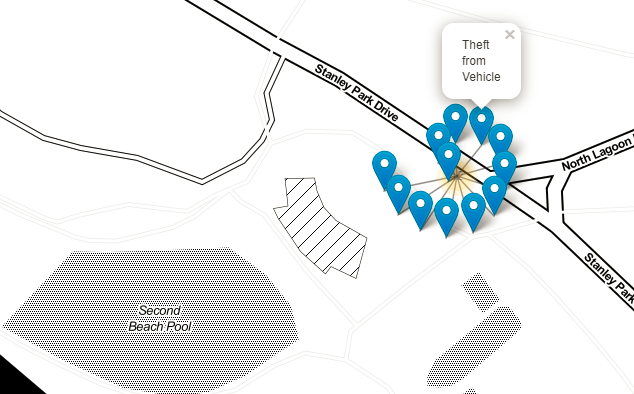

## Conclusion:
### Through this exploratory analysis of the Vancouver crime data:
### 1. I found that the most common crime in Vancouver is related to vehicle such "Theft from Vehicle", "Theft of Vehicle", "Theft of Bicycle" and "Vehicle Collision". Definitely, watch out for your bikes, motocycle, and cars. 
### 2. West End neighbourhood remain the most crime populated area from 2003 to 2019. The location record of crimes committed in West End can be used to draw a clear street map of West End.
### 3. The ocurrences of crimes are quite evenly distributed if crimes are counted by day or counted by month. However, crime occurs more in after work hours and midnight in Vancouver.
### 4. Folium is a great tool to visualize location data on openStreetMap.
### Please give an upvote if you like this kernel!

### Due to the limitation of Kaggle kernel, I only generate heatmap for selected neighbourhood to avoid exceed the kernel size limit. Feel free to fork it to play along with the data.